# Sparkify Project Workspace


In [991]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql import Window
from pyspark.sql.functions import max as smax
from pyspark.sql.functions import countDistinct, regexp_extract, when, count, avg
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.types import FloatType

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [992]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [993]:
path = "mini_sparkify_event_data.json"
sparkify_data = spark.read.json(path)

# Exploratory Data Analysis


### Define Churn

### Explore Data

I am going to start with some general analysis of the dataset. We need to understand the structure of data we are working with. First of all, let me check the schema of the data and the row example.

In [911]:
sparkify_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [912]:
sparkify_data.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

How many rows do we have in total?

In [913]:
print("Dataset contains {0} rows".format(sparkify_data.count()))

Dataset contains 286500 rows


So we have a dataset consisting of 286500 rows and 18 columns. Let's dig deeper in available features.

It's quite obvious that there are several text features which can not be used as categorical due to huge amount of different possible values. Text features are: "artist", "firstName", "lastName", "location", "song". Assuming those are just names, we can suppose they don't have much value for model building.

In [914]:
sd_valid = sparkify_data.dropna(how = "any", subset = ["userId", "sessionId"])
sd_valid.count()

286500

In [915]:
sd_valid = sparkify_data.filter(sparkify_data["userId"] != "")
sd_valid.count()

278154

Nice to see there are nu null missed values for "userId" and "sessionId". But there are a lot of values having empry string instead of userId. No point keeping those.

In [916]:
sparkify_data = sparkify_data.filter(sparkify_data.userId != '')

In [996]:
sparkify_data.select("userId").dropDuplicates().count()

226

What about categorical variables? looks like we've got quite a few.

In [917]:
sparkify_data.select("auth").dropDuplicates().sort("auth").show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [918]:
sparkify_data.filter(sparkify_data.auth == 'Cancelled').take(3)

[Row(artist=None, auth='Cancelled', firstName='Adriel', gender='M', itemInSession=104, lastName='Mendoza', length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Cancellation Confirmation', registration=1535623466000, sessionId=514, song=None, status=200, ts=1538943990000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='18'),
 Row(artist=None, auth='Cancelled', firstName='Diego', gender='M', itemInSession=56, lastName='Mckee', length=None, level='paid', location='Phoenix-Mesa-Scottsdale, AZ', method='GET', page='Cancellation Confirmation', registration=1537167593000, sessionId=540, song=None, status=200, ts=1539033046000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='32'),
 Row(artist=None, auth='Cancelled', firstName='Mason', gender='M', itemInSession=10, la

Cancel value seem to only appear at Cancellation Confirmation page, so no extra information here. I will not use this variable further.

In [997]:
sparkify_data.select("page").dropDuplicates().sort("page").collect()

[Row(page='About'),
 Row(page='Add Friend'),
 Row(page='Add to Playlist'),
 Row(page='Cancel'),
 Row(page='Cancellation Confirmation'),
 Row(page='Downgrade'),
 Row(page='Error'),
 Row(page='Help'),
 Row(page='Home'),
 Row(page='Login'),
 Row(page='Logout'),
 Row(page='NextSong'),
 Row(page='Register'),
 Row(page='Roll Advert'),
 Row(page='Save Settings'),
 Row(page='Settings'),
 Row(page='Submit Downgrade'),
 Row(page='Submit Registration'),
 Row(page='Submit Upgrade'),
 Row(page='Thumbs Down'),
 Row(page='Thumbs Up'),
 Row(page='Upgrade')]

Information about pages visited by user is definitely going to be one of the most important sources for frature engineering.

In [920]:
sparkify_data.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



Free users can only cancel service, while paid ones can either downgrade to free or cancel.

In [921]:
sparkify_data.select("method").dropDuplicates().sort("method").show()

+------+
|method|
+------+
|   GET|
|   PUT|
+------+



I dont think this one is going to be itneresting for feature engineering.

What we have left? "Gender" is somthing characterizing the user himself, definitely to be used. "ItemInSession" can be used to track the whole session, same as "length". "Registration" does not seem to be too informative. "UserAgent" - who knows, maybe we can extract something useful here. 

Now that we have some general knowledge about the dataset, it's time to turn it into something more valuable for model building. Let me start with defining Churn users. Those would be the ones cancelling the service or downgrading to free tier.

In [922]:
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' or x == 'Submit Downgrade' else 0, IntegerType())
sparkify_data = sparkify_data.withColumn("churn", churn_event("page"))

In [923]:
windowval = Window.partitionBy("userId")
sparkify_data = sparkify_data.withColumn("churn_user", smax(col("churn")).over(windowval))

In [924]:
sparkify_data.filter(sparkify_data.churn_user == 0).select("userId").dropDuplicates().count()

133

In [925]:
sparkify_data.filter(sparkify_data.churn_user == 1).select("userId").dropDuplicates().count()

92

I have first only marked events which are treated as churn, then all the records for churn and non-churn users.

Dataset is almost balanced. 

Now I am going to analyze behavior of users belonging to two different groups and hopefully find something I can further use as features.

I see the "page" data as the largest possible source for potential features. 

I am starting with simply counting number of each page attendance for every user in the dataset. In order to make this analysis more descriptive I will create a pandas dataset and build some graphs. Dataframe will consist on some aggregational numbers, so it will be pretty small even for a large dataset, I don't see any issues with storing it in a variable.

In [926]:
pages = ['Add Friend', 'Add to Playlist', 'Error', 'Help', 'Home', 'NextSong', 'Roll Advert', \
         'Save Settings', 'Settings', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up']

In [927]:
sparkify_df = sparkify_data.filter(col("page").isin(pages)).groupby(["userId", "page"]) \
    .count().toPandas()

In [928]:
sparkify_df.head()

,userId,page,count
0,88,Home,85
1,88,NextSong,2045
2,13,Add to Playlist,37
3,87,Home,56
4,59,Add Friend,16


For every user-page pair I've counted the anount of records. I also want to know what group user belongs to.

In [929]:
user_churn = sparkify_data.select(["userId", "churn_user"]).dropDuplicates().toPandas()

The dataframe is now in "melt" view, let me pivot it, merge with "churn" column and clean from nulls.

In [930]:
pages_summary = sparkify_df.pivot(index = "userId", columns = "page", values = "count")

In [931]:
pages_summary.head()

page,Add Friend,Add to Playlist,Error,Help,Home,NextSong,Roll Advert,Save Settings,Settings,Submit Upgrade,Thumbs Down,Thumbs Up
userId,,,,,,,,,,,,
10,12.0,9.0,NaN,1.0,30.0,673.0,1.0,1.0,7.0,NaN,4.0,37.0
100,49.0,61.0,3.0,18.0,105.0,2682.0,25.0,5.0,11.0,1.0,27.0,148.0
100001,2.0,3.0,1.0,1.0,11.0,133.0,14.0,NaN,1.0,NaN,2.0,8.0
100002,1.0,5.0,NaN,NaN,6.0,195.0,3.0,NaN,NaN,NaN,NaN,5.0
100003,NaN,2.0,NaN,1.0,7.0,51.0,9.0,NaN,NaN,NaN,NaN,3.0


In [932]:
pages_summary.fillna(0, inplace=True)

In [933]:
pages_summary = pages_summary.merge(user_churn, on='userId')

In [934]:
pages_summary.head()

,userId,Add Friend,Add to Playlist,Error,Help,Home,NextSong,Roll Advert,Save Settings,Settings,Submit Upgrade,Thumbs Down,Thumbs Up,churn_user
0,10,12.0,9.0,0.0,1.0,30.0,673.0,1.0,1.0,7.0,0.0,4.0,37.0,0
1,100,49.0,61.0,3.0,18.0,105.0,2682.0,25.0,5.0,11.0,1.0,27.0,148.0,1
2,100001,2.0,3.0,1.0,1.0,11.0,133.0,14.0,0.0,1.0,0.0,2.0,8.0,1
3,100002,1.0,5.0,0.0,0.0,6.0,195.0,3.0,0.0,0.0,0.0,0.0,5.0,0
4,100003,0.0,2.0,0.0,1.0,7.0,51.0,9.0,0.0,0.0,0.0,0.0,3.0,1


This looks like and old good dataframe now! Easiest I can do is comparing meand for all possible actions (pages).

In [935]:
pages_summary.groupby(["churn_user"]).mean()

,Add Friend,Add to Playlist,Error,Help,Home,NextSong,Roll Advert,Save Settings,Settings,Submit Upgrade,Thumbs Down,Thumbs Up
churn_user,,,,,,,,,,,,
0,16.255639,24.285714,1.052632,5.383459,37.285714,853.857143,11.857143,1.240602,5.744361,0.488722,8.609023,47.045113
1,22.989130,35.826087,1.217391,8.021739,55.684783,1245.054348,25.608696,1.576087,8.152174,1.021739,15.228261,68.413043


Looks like pretty significant difference can be observed in most of them. I also want build a scatter plot matrix using different colors for user groups, it definitely will be huge and non-readable, so I will only select several features.

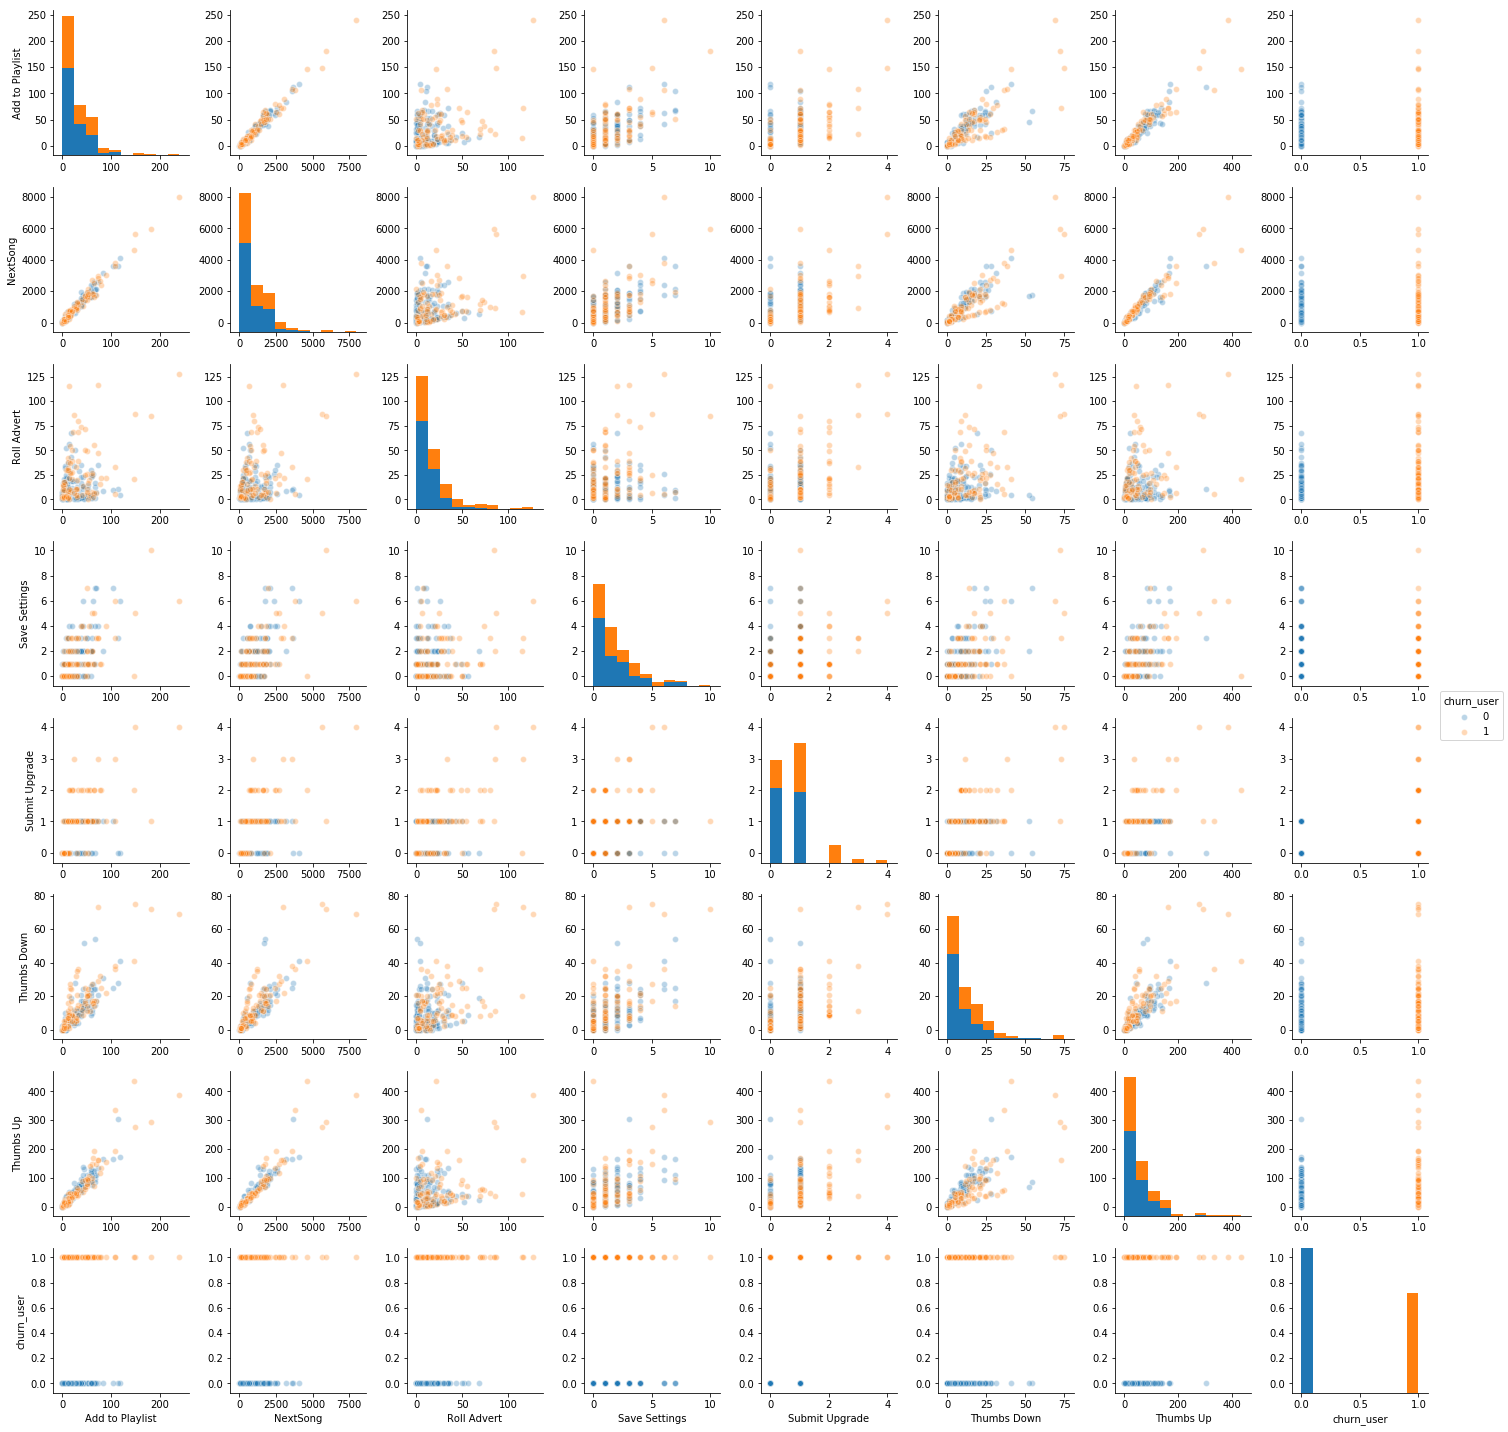

In [1006]:
sns.pairplot(pages_summary.drop(columns=["userId", "Add Friend", "Error", "Help", "Home", "Settings"]), hue='churn_user', plot_kws={'alpha': 0.3})

Closeness to 0 for some actions makes it a bit hard to analyze. Nevertheless, this data is definitely going to be used.

No doubt "gender" column will be included too. This is almost the only (except for name and location) data piece describing the user him(her)self.

In [937]:
sparkify_data.select(["userId", "gender", "churn_user"]).dropDuplicates().groupby(["churn_user", "gender"]).count().show()

+----------+------+-----+
|churn_user|gender|count|
+----------+------+-----+
|         1|     F|   43|
|         0|     M|   72|
|         1|     M|   49|
|         0|     F|   61|
+----------+------+-----+



We've got length for songs played, why not use those? Maybe users who listen more tend to churn less?

In [938]:
sparkify_data.select(["userId", "length", "churn_user"]).groupby(["churn_user", "userId"]).sum("length") \
    .groupby("churn_user").avg("sum(length)").show()

+----------+------------------+
|churn_user|  avg(sum(length))|
+----------+------------------+
|         1| 310145.8052251084|
|         0|212723.36891646608|
+----------+------------------+



Not quite what I was expecting to be honest, on the average "churn" users tend to listen more. Still, difference seem to be pretty impressive.

Next we can extract is sessionIds. For each user I want to get average and maximum length of the session.

In [939]:
sparkify_data.select(["userId", "sessionId", "churn_user"]).groupby(["churn_user", "userId", "sessionId"]).count() \
    .groupby(["churn_user", "userId"]).avg("count").groupby("churn_user").avg("avg(count)").show()

+----------+-----------------+
|churn_user|  avg(avg(count))|
+----------+-----------------+
|         1|82.98641012443774|
|         0|86.10151882274668|
+----------+-----------------+



In [940]:
sparkify_data.select(["userId", "sessionId", "churn_user"]).groupby(["churn_user", "userId", "sessionId"]).count() \
    .groupby(["churn_user", "userId"]).max("count").groupby("churn_user").avg("max(count)").show()

+----------+-----------------+
|churn_user|  avg(max(count))|
+----------+-----------------+
|         1|291.0326086956522|
|         0|268.6766917293233|
+----------+-----------------+



In [941]:
sessions_max_lengths = sparkify_data.select(["userId", "sessionId", "churn_user"]).groupby(["churn_user", "userId", "sessionId"]).count() \
    .groupby(["churn_user", "userId"]).max("count").toPandas()
sessions_max_lengths.head()

,churn_user,userId,max(count)
0,0,100010,112
1,0,200002,152
2,1,125,11
3,0,124,519
4,1,51,599


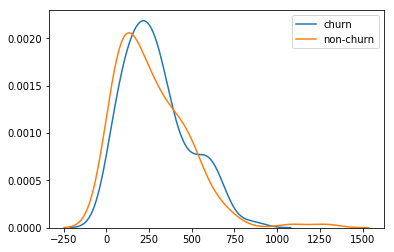

In [942]:
sns.kdeplot(sessions_max_lengths['max(count)'][sessions_max_lengths['churn_user'] == 1], 
            label='churn')
sns.kdeplot(sessions_max_lengths['max(count)'][sessions_max_lengths['churn_user'] == 0], 
            label='non-churn')

Distriutions of maximum session length seem to differ. Not too much, but it's quite observable.

As all the rows in the dataset have timestamp, we can generate time-based statistics. Data we have only covers 2 month, so I will stick to days. First, we need to mark each row with month and day.

In [943]:
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). day)

In [944]:
sparkify_data = sparkify_data.withColumn("month", get_month(sparkify_data.ts))
sparkify_data = sparkify_data.withColumn("day", get_day(sparkify_data.ts))

In [945]:
sparkify_data.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, churn_user=0, month='10', day='8')

Next, I will gather aggregated statistics based on date. How much actions does user perform daily? 

In [946]:
sparkify_data.select(["userId", "month", "day", "churn_user"]).groupby(["churn_user", "userId", "month", "day"]) \
    .count().groupby(["churn_user", "userId"]).avg("count").groupby("churn_user").avg("avg(count)").show()

+----------+-----------------+
|churn_user|  avg(avg(count))|
+----------+-----------------+
|         1| 82.8226520787324|
|         0|74.54174950660935|
+----------+-----------------+



In [947]:
avg_actions_per_day = sparkify_data.select(["userId", "month", "day", "churn_user"]) \
    .groupby(["churn_user", "userId", "month", "day"]) \
    .count().groupby(["churn_user", "userId"]).avg("count").toPandas()
avg_actions_per_day.head()

,churn_user,userId,avg(count)
0,0,114,85.944444
1,1,12,106.400000
2,1,103,119.090909
3,0,200012,42.000000
4,0,82,102.450000


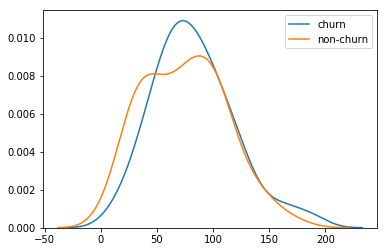

In [948]:
sns.kdeplot(avg_actions_per_day['avg(count)'][avg_actions_per_day['churn_user'] == 1], 
            label='churn')
sns.kdeplot(avg_actions_per_day['avg(count)'][avg_actions_per_day['churn_user'] == 0], 
            label='non-churn')

Again, weirdly, "churn" suers tend to be more active. What about concrete actions like listeting to a song or adding a friend?

In [949]:
sparkify_data.filter(sparkify_data.page == 'NextSong').select(["userId", "month", "day", "churn_user"]) \
    .groupby(["churn_user", "userId", "month", "day"]) \
    .count().groupby(["churn_user", "userId"]).avg("count").groupby("churn_user").avg("avg(count)").show()

+----------+------------------+
|churn_user|   avg(avg(count))|
+----------+------------------+
|         1| 68.26173643764719|
|         0|61.766273417375395|
+----------+------------------+



In [950]:
avg_playsong_per_day = sparkify_data.filter(sparkify_data.page == 'NextSong'). \
    select(["userId", "month", "day", "churn_user"]) \
    .groupby(["churn_user", "userId", "month", "day"]) \
    .count().groupby(["churn_user", "userId"]).avg("count").toPandas()
avg_playsong_per_day.head()

,churn_user,userId,avg(count)
0,0,114,76.000000
1,1,12,86.700000
2,1,103,107.300000
3,0,200012,33.000000
4,0,82,94.722222


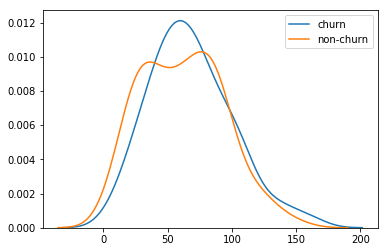

In [951]:
sns.kdeplot(avg_playsong_per_day['avg(count)'][avg_playsong_per_day['churn_user'] == 1], 
            label='churn')
sns.kdeplot(avg_playsong_per_day['avg(count)'][avg_playsong_per_day['churn_user'] == 0], 
            label='non-churn')

In [952]:
sparkify_data.filter(sparkify_data.page == 'Add Friend').select(["userId", "month", "day", "churn_user"]) \
    .groupby(["churn_user", "userId", "month", "day"]) \
    .count().groupby(["churn_user", "userId"]).avg("count").groupby("churn_user").avg("avg(count)").show()

+----------+------------------+
|churn_user|   avg(avg(count))|
+----------+------------------+
|         1| 2.636175399280173|
|         0|2.7418091469324066|
+----------+------------------+



In [953]:
sparkify_data.filter(sparkify_data.page == 'Add to Playlist').select(["userId", "month", "day", "churn_user"]) \
    .groupby(["churn_user", "userId", "month", "day"]) \
    .count().groupby(["churn_user", "userId"]).avg("count").groupby("churn_user").avg("avg(count)").show()

+----------+------------------+
|churn_user|   avg(avg(count))|
+----------+------------------+
|         1|2.9256237521496447|
|         0|2.6979759726527557|
+----------+------------------+



In [954]:
sparkify_data.filter(sparkify_data.page == 'Thumbs Up').select(["userId", "month", "day", "churn_user"]) \
    .groupby(["churn_user", "userId", "month", "day"]) \
    .count().groupby(["churn_user", "userId"]).avg("count").groupby("churn_user").avg("avg(count)").show()

+----------+-----------------+
|churn_user|  avg(avg(count))|
+----------+-----------------+
|         1|4.506563960862261|
|         0|4.252070779972376|
+----------+-----------------+



In [955]:
sparkify_data.filter(sparkify_data.page == 'Error').select(["userId", "month", "day", "churn_user"]) \
    .groupby(["churn_user", "userId", "month", "day"]) \
    .count().groupby(["churn_user", "userId"]).avg("count").groupby("churn_user").avg("avg(count)").show()

+----------+------------------+
|churn_user|   avg(avg(count))|
+----------+------------------+
|         1|1.0933333333333335|
|         0|1.0950248756218908|
+----------+------------------+



For me differences for all the pages, except 'Next song', and maybe 'Add to playlist' do not look meaningful.

Next, I want to check how much active days user has per month. Assuming we only have data for October and November (and very little for December, I will ignore it here), I will count those separately: active days in October and active days in November.

In [956]:
sparkify_data.filter(sparkify_data.month == 10).select(["userId", "month", "day", "churn_user"]) \
    .groupby(["churn_user", "userId", "day"]).count().groupby(["churn_user", "userId"]).count(). \
    groupby("churn_user").avg("count").show()

+----------+------------------+
|churn_user|        avg(count)|
+----------+------------------+
|         1|10.076086956521738|
|         0| 6.586776859504132|
+----------+------------------+



In [957]:
sparkify_data.filter(sparkify_data.month == 11).select(["userId", "month", "day", "churn_user"]) \
    .groupby(["churn_user", "userId", "day"]).count().groupby(["churn_user", "userId"]).count(). \
    groupby("churn_user").avg("count").show()

+----------+-----------------+
|churn_user|       avg(count)|
+----------+-----------------+
|         1|9.193548387096774|
|         0|            6.608|
+----------+-----------------+



This looks like something we can use.

Last thing I want to investigate is device user runs the application from. I'll start with extracting data from "userAgent" columns.

In [958]:
sparkify_data = sparkify_data.withColumn("device", regexp_extract(sparkify_data.userAgent, r"\((.+?);", 1))

In [959]:
sparkify_data.select("device").dropDuplicates().show()

+--------------+
|        device|
+--------------+
|          iPad|
|           X11|
|Windows NT 6.3|
|        iPhone|
|Windows NT 6.2|
|     Macintosh|
|    compatible|
|Windows NT 6.0|
|Windows NT 6.1|
|              |
+--------------+



Couple of these values need to be checked.

In [960]:
sparkify_data.filter(sparkify_data.device == '').select("userAgent").dropDuplicates().collect()

[Row(userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"')]

In [961]:
sparkify_data.filter(sparkify_data.device == 'X11').select("userAgent").dropDuplicates().collect()

[Row(userAgent='Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (X11; Linux x86_64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"')]

In [962]:
sparkify_data.filter(sparkify_data.device == 'compatible').select("userAgent").dropDuplicates().collect()

[Row(userAgent='Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0)'),
 Row(userAgent='Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)'),
 Row(userAgent='Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; WOW64; Trident/6.0)')]

Alright, empty value always comes from Windows PC, as well as 'compatible'. 'X11' is Linux PC.

In [963]:
sparkify_data = sparkify_data.withColumn("device_new", when(col("device") \
        .isin(["Windows NT 6.3", "Windows NT 6.2", "Windows NT 6.0, Windows NT 6.1", "compatible", ""]), "Windows PC") \
        .when(sparkify_data.device == "X11", "Linux PC").when(sparkify_data.device == "Macintosh", "Mac PC") \
        .when(col("device").isin(["iPad", "iPhone"]), "iOS device"))

In [964]:
sparkify_data.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, churn_user=0, month='10', day='8', device='iPhone', device_new='iOS device')

In [965]:
devices_df = sparkify_data.select(["userId", "churn_user", "device_new"]).dropDuplicates().sort("userId").toPandas()

In [966]:
devices_df.head()

,userId,churn_user,device_new
0,10,0,Mac PC
1,100,1,None
2,100001,1,Mac PC
3,100002,0,None
4,100003,1,None


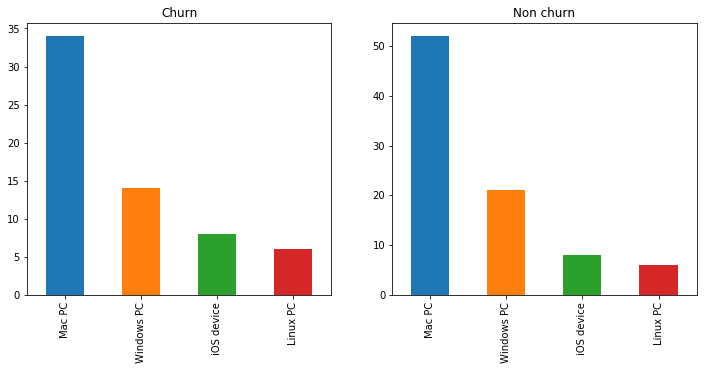

In [1007]:
pylab.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)
plt.title('Churn')
devices_df['device_new'][devices_df['churn_user'] == 1].value_counts().plot(kind='bar')
ax1 = plt.subplot(1, 2, 2)
plt.title('Non churn')
devices_df['device_new'][devices_df['churn_user'] == 0].value_counts().plot(kind='bar')

Does not looks like distributions are significantly different for two groups of users.

Overall I believe the needed features have been found and I can move to feature extraction now.

# Feature Engineering


To sum up the preceeding analysis, here is the list of features I am going to stick to:

- Gender
- Total counts for 12 types of pages (stored in pages list)
- Total length of listened songs
- Average session length
- Maximum session length
- Average actions performed daily
- Average songs listened daily
- Average adds to playlist daily
- Active days in October
- Active days in November

I will start with creating new dataframe by extracting most straightforward features: userId itself, gender and target variable - churn_user.

In [968]:
sparkify_df = sparkify_data.select(["userId", "gender", "churn_user"]).dropDuplicates()

In order to get counts for all the page types I am interested in, I will count the needed aggregate in a small dataframe and then join it to newly created one.

In [969]:
for page in pages:
    tmp = sparkify_data.filter(sparkify_data.page == page).groupby("userId").agg(count("page").alias(page.lower()))
    sparkify_df = sparkify_df.join(tmp, on = "userId", how='left')

In [970]:
sparkify_df = sparkify_df.withColumnRenamed("add Friend", "add_friend")
sparkify_df = sparkify_df.withColumnRenamed("add to playlist", "add_to_playlist")
sparkify_df = sparkify_df.withColumnRenamed("roll advert", "roll_advert")
sparkify_df = sparkify_df.withColumnRenamed("save settings", "save_settings")
sparkify_df = sparkify_df.withColumnRenamed("submit upgrade", "submit_upgrade")
sparkify_df = sparkify_df.withColumnRenamed("thumbs down", "thumbs_down")
sparkify_df = sparkify_df.withColumnRenamed("thumbs up", "thumbs_up")
sparkify_df = sparkify_df.withColumnRenamed("nextsong", "next_song")

Next one are total length of songs listened and session length. Generally I am going to use same approach for all the features extraction.

In [971]:
tmp = sparkify_data.select(["userId", "length"]).groupby("userId").sum("length")
sparkify_df = sparkify_df.join(tmp, on = "userId", how='left')
sparkify_df = sparkify_df.withColumnRenamed("sum(length)", "total_songs_length")

In [972]:
tmp = sparkify_data.select(["userId", "sessionId"]).groupby(["userId", "sessionId"]).count() \
    .groupby(["userId"]).agg(avg("count"), smax("count"))
sparkify_df = sparkify_df.join(tmp, on = "userId", how='left')
sparkify_df = sparkify_df.withColumnRenamed("avg(count)", "avg_session_length")
sparkify_df = sparkify_df.withColumnRenamed("max(count)", "max_session_length")

In [973]:
sparkify_df.head()

Row(userId='100010', gender='F', churn_user=0, add_friend=4, add_to_playlist=7, error=None, help=2, home=11, next_song=275, roll_advert=52, save_settings=None, settings=None, submit_upgrade=None, thumbs_down=5, thumbs_up=17, total_songs_length=66940.89735000003, avg_session_length=54.42857142857143, max_session_length=112)

Moving to date-related data. Here we will need to perform grouping based on day and month.

In [974]:
tmp = sparkify_data.select(["userId", "month", "day"]).groupby(["userId", "month", "day"]) \
    .count().groupby("userId").avg("count")
sparkify_df = sparkify_df.join(tmp, on = "userId", how='left')
sparkify_df = sparkify_df.withColumnRenamed("avg(count)", "avg_actions_daily")

In [975]:
tmp = sparkify_data.filter(sparkify_data.page == "NextSong").select(["userId", "month", "day"]) \
    .groupby(["userId", "month", "day"]) \
    .count().groupby("userId").avg("count")
sparkify_df = sparkify_df.join(tmp, on = "userId", how='left')
sparkify_df = sparkify_df.withColumnRenamed("avg(count)", "avg_songs_daily")

In [976]:
tmp = sparkify_data.filter(sparkify_data.page == "Add to Playlist").select(["userId", "month", "day"]) \
    .groupby(["userId", "month", "day"]) \
    .count().groupby("userId").avg("count")
sparkify_df = sparkify_df.join(tmp, on = "userId", how='left')
sparkify_df = sparkify_df.withColumnRenamed("avg(count)", "avg_adds_daily")

In [977]:
sparkify_df.head()

Row(userId='100010', gender='F', churn_user=0, add_friend=4, add_to_playlist=7, error=None, help=2, home=11, next_song=275, roll_advert=52, save_settings=None, settings=None, submit_upgrade=None, thumbs_down=5, thumbs_up=17, total_songs_length=66940.89735000003, avg_session_length=54.42857142857143, max_session_length=112, avg_actions_daily=54.42857142857143, avg_songs_daily=39.285714285714285, avg_adds_daily=1.4)

And the last, active days per month

In [978]:
tmp = sparkify_data.filter(sparkify_data.month == 10).select(["userId", "month", "day"]) \
    .groupby(["userId", "day"]).count().groupby(["userId"]).count()
sparkify_df = sparkify_df.join(tmp, on = "userId", how='left')
sparkify_df = sparkify_df.withColumnRenamed("count", "active_days_october")

In [979]:
tmp = sparkify_data.filter(sparkify_data.month == 11).select(["userId", "month", "day"]) \
    .groupby(["userId", "day"]).count().groupby(["userId"]).count()
sparkify_df = sparkify_df.join(tmp, on = "userId", how='left')
sparkify_df = sparkify_df.withColumnRenamed("count", "active_days_november")

Certain values may now be empty (None) if, for example, user never has peformed certain type of action. We need to replace those with 0.

In [980]:
sparkify_df = sparkify_df.fillna(0)

In [981]:
sparkify_df.head()

Row(userId='100010', gender='F', churn_user=0, add_friend=4, add_to_playlist=7, error=0, help=2, home=11, next_song=275, roll_advert=52, save_settings=0, settings=0, submit_upgrade=0, thumbs_down=5, thumbs_up=17, total_songs_length=66940.89735000003, avg_session_length=54.42857142857143, max_session_length=112, avg_actions_daily=54.42857142857143, avg_songs_daily=39.285714285714285, avg_adds_daily=1.4, active_days_october=4, active_days_november=3)

And the dataset with total of 21 features is ready for model building!

In fact not yet. First we need to prepare dataset for modeling. Each row will have column 'features' containing all existing features grouped into vector and column 'label' - this one we already have as 'churn_user'.

There is one feature which needs to be additionally prepared - gender. This needs to be converted to a number.

In [982]:
label_indexer = StringIndexer().setInputCol("gender").setOutputCol("gender_int")
label_indexer_model = label_indexer.fit(sparkify_df)
sparkify_df = label_indexer_model.transform(sparkify_df)

In [983]:
assembler = VectorAssembler().setInputCols(["gender_int", "add_friend", "add_to_playlist", "error", "help", "home", \
            "next_song", "roll_advert", "save_settings", "settings", "submit_upgrade", "thumbs_down", "thumbs_up", \
            "total_songs_length", "avg_session_length", "max_session_length", "avg_actions_daily", "avg_songs_daily", \
            "avg_adds_daily", "active_days_october", "active_days_november"]).setOutputCol("features")
sparkify_df = assembler.transform(sparkify_df)

Next - bringing all numeric features to same scale (for logistic regression). I will use StandardScaler - it brings data to the distribution having mean 0 and deviance 1.

In [984]:
scaler = StandardScaler().setInputCol("features").setOutputCol("scaled_features")
scaler_model = scaler.fit(sparkify_df)
sparkify_df = scaler_model.transform(sparkify_df)

In [985]:
sparkify_df = sparkify_df.withColumnRenamed("churn_user", "label")

In [986]:
sparkify_df = sparkify_df.withColumn("label", sparkify_df["label"].cast(FloatType()))

In [987]:
sparkify_df.head()

Row(userId='100010', gender='F', label=0.0, add_friend=4, add_to_playlist=7, error=0, help=2, home=11, next_song=275, roll_advert=52, save_settings=0, settings=0, submit_upgrade=0, thumbs_down=5, thumbs_up=17, total_songs_length=66940.89735000003, avg_session_length=54.42857142857143, max_session_length=112, avg_actions_daily=54.42857142857143, avg_songs_daily=39.285714285714285, avg_adds_daily=1.4, active_days_october=4, active_days_november=3, gender_int=1.0, features=DenseVector([1.0, 4.0, 7.0, 0.0, 2.0, 11.0, 275.0, 52.0, 0.0, 0.0, 0.0, 5.0, 17.0, 66940.8974, 54.4286, 112.0, 54.4286, 39.2857, 1.4, 4.0, 3.0]), scaled_features=DenseVector([2.0013, 0.1943, 0.214, 0.0, 0.2761, 0.2326, 0.2489, 2.413, 0.0, 0.0, 0.0, 0.3823, 0.2596, 0.2431, 1.1092, 0.5558, 1.4756, 1.2249, 1.09, 0.6639, 0.4996]))

In [988]:
sparkify_df.count()

225

And now we are truly ready.

# Modeling


I am going to try 3 different algorythms: Logistic Regression, Random Forest and Gradient Boosting.

Let me start with defining function which will calculate several metrics. Assuming somewhat class disbalance, best metric to base on seems to be F1 score. Still, I will also calculate accuracy as disbalance is not so serious.

In [781]:
def print_metrics(results):
    tp = results.filter(results.label == 1.0).filter(results.prediction == 1.0).count()
    fp = results.filter(results.label == 0.0).filter(results.prediction == 1.0).count()
    fn = results.filter(results.label == 1.0).filter(results.prediction == 0.0).count()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)
    acc = results.filter(results.label == results.prediction).count()/results.count()
    print("Precision: {0}, Recall: {1}, F1-score: {2}, Accuracy: {3}".format(precision, recall, f1, acc))

Starting with splitting data into 3 parts: train, test and validation. While test part is going to be basis for determining best model, validation will be the one showing final performance of the best selected one.

In [1010]:
train, test, validation = sparkify_df.randomSplit([0.6, 0.2, 0.2], seed=10)
print(test.filter(test.label == 1.0).count())
print(test.filter(test.label == 0.0).count())

16
27


Here is the first model - Logistic Regression. Dataset is not big and amount of parameters to be tuned is not great. So I will tune the parameters manually rather that using grid seach.

In [1065]:
classifier_lr = LogisticRegression(featuresCol="scaled_features", labelCol="label", maxIter=10, regParam=0.0, elasticNetParam=0.8)

In [1066]:
model_lr = classifier_lr.fit(train)

In [1067]:
results = model_lr.transform(test)
print_metrics(results)

Precision: 0.7142857142857143, Recall: 0.625, F1-score: 0.6666666666666666, Accuracy: 0.7674418604651163


In [1068]:
classifier_lr = LogisticRegression(featuresCol="scaled_features", labelCol="label", maxIter=100, regParam=0.0, elasticNetParam=0.8)

In [1069]:
model_lr = classifier_lr.fit(train)
results = model_lr.transform(test)
print_metrics(results)

Precision: 0.631578947368421, Recall: 0.75, F1-score: 0.6857142857142857, Accuracy: 0.7441860465116279


Increasing number of iterations makes it possible to make F1 score slightly higher, mostly by increasing recall, but dropping accuracy at the same time. Introducing regularization drops performance a lot. That’s explainable: dataset is fairly small.

Moving to Random Forest.

In [1042]:
classifier_forest = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10, maxDepth=7)

In [1043]:
model_forest = classifier_forest.fit(train)
results = model_forest.transform(test)
print_metrics(results)

Precision: 0.7692307692307693, Recall: 0.625, F1-score: 0.6896551724137931, Accuracy: 0.7906976744186046


After some parameter tuning I was able to get the following:

In [1045]:
classifier_forest = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50, maxDepth=5)

In [1046]:
model_forest = classifier_forest.fit(train)
results = model_forest.transform(test)
print_metrics(results)

Precision: 0.9166666666666666, Recall: 0.6875, F1-score: 0.7857142857142857, Accuracy: 0.8604651162790697


Much better that Logistic Regression, although it has lower Recall value. Minding the nature of our problem, we should note recall is especially important here: it shows how good we are able to find potentially churn users.

In [1048]:
classifier_gb = GBTClassifier(featuresCol="features", labelCol="label", maxIter=10, maxDepth=7, subsamplingRate=0.8)

In [1049]:
model_gb = classifier_gb.fit(train)

In [1050]:
results = model_gb.transform(test)
print_metrics(results)

Precision: 0.5882352941176471, Recall: 0.625, F1-score: 0.6060606060606061, Accuracy: 0.6976744186046512


In [1053]:
classifier_gb = GBTClassifier(featuresCol="features", labelCol="label", maxIter=50, maxDepth=5, subsamplingRate=1.0)

In [1054]:
model_gb = classifier_gb.fit(train)
results = model_gb.transform(test)
print_metrics(results)

Precision: 0.5882352941176471, Recall: 0.625, F1-score: 0.6060606060606061, Accuracy: 0.6976744186046512


Random Forest definitely beats it.
Going back to slight class disbalance, let me try to introduce class weights: rows belonging to class 1 get higher weigh as the class is smaller. I will train logistic regression with the weighted dataset.


In [1055]:
pos_w = sparkify_df.filter(sparkify_df.label == 1.0).count()/sparkify_df.count()
get_weights = udf(lambda x: pos_w if x == 0 else (1-pos_w), DoubleType())
sparkify_df_weighted = sparkify_df.withColumn("class_weight", get_weights("label"))

In [1056]:
train_w, test_w, validation_w = sparkify_df_weighted.randomSplit([0.6, 0.2, 0.2], seed=10)

In [1061]:
classifier_lr_w = LogisticRegression(featuresCol="scaled_features", labelCol="label", weightCol="class_weight", maxIter=100, regParam=0.0, elasticNetParam=0.8)

In [1063]:
model_lr_w = classifier_lr_w.fit(train_w)

In [1064]:
results_w = model_lr_w.transform(test_w)
print_metrics(results_w)

Precision: 0.5714285714285714, Recall: 0.75, F1-score: 0.6486486486486486, Accuracy: 0.6976744186046512


Based on performed test, the winning model is Random Forest. Final performance is evaluated on validation dataset:

In [1060]:
res = model_forest.transform(validation)
print_metrics(res)

Precision: 1.0, Recall: 0.625, F1-score: 0.7692307692307693, Accuracy: 0.7857142857142857


Can I say the results are super impressive? No. There deinitely is more room for investigation and optimization, but isn't that great? Dataset only consists of a bit more than 200 rows, in real life this would be thousands, even millions of rows. Even with a small dataset however it is possibe to build an adequately performing model.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.